In [1]:
from __future__ import print_function
import time
from typing import Callable, Optional
import torch
import torch.nn.functional as F
import numpy as np
from torch.utils.data import DataLoader
from pathlib import Path

from IRS.dataloader.IRSLoader import IRSDataset
from IRS.utils.AverageMeter import AverageMeter
from IRS.utils.common import logger
from IRS.losses.multiscaleloss import EPE
from IRS.dataloader.IRSLoader import IRSDataset
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from IRS.networks.DispNetC import DispNetC
from torch.utils.data import DataLoader
import torchvision.models as models
from typing import List


class DisparityTrainer(object):
    def __init__(
        self,
        lr: float,
        device: str,
        trainlist: str,
        vallist: str,
        datapath: str,
        batch_size: int,
        maxdisp: int,
        criterion: Callable,
        pretrain: Optional[str]=None,
        num_workers=4
    ):
        super(DisparityTrainer, self).__init__()
        self.lr = lr
        self.current_lr = lr
        self.device = device
        self.trainlist = trainlist
        self.vallist = vallist
        self.datapath = datapath
        self.batch_size = batch_size
        self.pretrain = pretrain
        self.maxdisp = maxdisp
        self.num_workers = num_workers
        self.criterion = criterion
        self.epe = EPE

        self.initialize()

    def _prepare_dataset(self):
        train_dataset = IRSDataset(txt_file=self.trainlist, root_dir=self.datapath, phase='train', load_norm=False)
        test_dataset = IRSDataset(txt_file=self.vallist, root_dir=self.datapath, phase='test', load_norm=False)
        self.img_size = train_dataset.get_img_size()
        self.scale_size = train_dataset.get_scale_size()
        self.focal_length = train_dataset.get_focal_length()

        self.train_loader = DataLoader(
            train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            pin_memory=True,
        )

        self.test_loader = DataLoader(
            test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True,
        )
        self.num_batches_per_epoch = len(self.train_loader)

    def _build_net(self):
        self.net = DispNetC(batchNorm=False, input_channel=3, maxdisp=30).to(self.device)

        if self.pretrain is not None:
            assert Path(self.pretrain).exists(), f"{self.pretrain} does not exist"
            model_data = torch.load(self.pretrain)
            logger.info("Load pretrain model: %s", self.pretrain)
            if "state_dict" in model_data.keys():
                self.net.load_state_dict(model_data["state_dict"])
            elif "model" in model_data.keys():
                self.net.load_state_dict(model_data["model"])
            else:
                self.net.load_state_dict(model_data)

    def _build_optimizer(self):
        beta = 0.999
        momentum = 0.9
        self.optimizer = torch.optim.Adam(
            filter(lambda p: p.requires_grad, self.net.parameters()),
            self.lr,
            betas=(momentum, beta),
            amsgrad=True,
        )

    def initialize(self):
        self._prepare_dataset()
        self._build_net()
        self._build_optimizer()

    def adjust_learning_rate(self, epoch):
        cur_lr = self.lr / (2 ** (epoch // 10))
        for param_group in self.optimizer.param_groups:
            param_group["lr"] = cur_lr
        self.current_lr = cur_lr
        return cur_lr

    def train_one_epoch(self, epoch):
        batch_time = AverageMeter()
        data_time = AverageMeter()
        losses = AverageMeter()
        EPEs = AverageMeter()
        # switch to train mode
        self.net.train()
        end = time.time()
        cur_lr = self.adjust_learning_rate(epoch)
        logger.info("learning rate of epoch %d: %f." % (epoch, cur_lr))

        for i_batch, sample_batched in enumerate(self.train_loader):

            left_input = sample_batched["img_left"].to(self.device)
            right_input = sample_batched["img_right"].to(self.device)
            input = torch.cat((left_input, right_input), 1)
            target_disp = sample_batched["gt_disp"].to(self.device)
            data_time.update(time.time() - end)

            self.optimizer.zero_grad()

            disps = self.net(input)
            # loss = self.criterion(left_input, right_input, disps[0])
            loss = nn.L1Loss()(disps[0], target_disp)
            epe = self.epe(disps[0], target_disp)
            # record loss and EPE
            losses.update(loss.data.item(), input.size(0))
            EPEs.update(epe.data.item(), input.size(0))
            # compute gradient and do SGD step
            loss.backward()
            self.optimizer.step()

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i_batch % 10 == 0:
                logger.info(
                    "Epoch: [{0}][{1}/{2}]\t"
                    "Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t"
                    "Data {data_time.val:.3f} ({data_time.avg:.3f})\t"
                    "Loss {loss.val:.3f} ({loss.avg:.3f})\t"
                    "EPE {EPE.val:.3f} ({EPE.avg:.3f})\t".format(
                        epoch,
                        i_batch,
                        self.num_batches_per_epoch,
                        batch_time=batch_time,
                        data_time=data_time,
                        loss=losses,
                        EPE=EPEs,
                    )
                )

        return losses.avg, EPEs.avg

    def validate(self):
        batch_time = AverageMeter()
        EPEs = AverageMeter()
        # switch to evaluate mode
        end = time.time()
        self.net.eval()
        for i, sample_batched in enumerate(self.test_loader):

            left_input = sample_batched["img_left"].to(self.device)
            right_input = sample_batched["img_right"].to(self.device)
            left_input = F.interpolate(left_input, self.scale_size, mode="bilinear")
            right_input = F.interpolate(right_input, self.scale_size, mode="bilinear")

            input = torch.cat((left_input, right_input), 1)

            target_disp = sample_batched["gt_disp"].to(self.device)

            with torch.no_grad():
                disp = self.net(input)[0]

            # upsampling the predicted disparity map
            disp = nn.Upsample(size=target_disp.shape[2:], mode='bilinear')(disp)
            epe = self.epe(disp, target_disp)

            # record loss and EPE
            EPEs.update(epe.data.item(), input.size(0))
            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            logger.info(
                "Test: [{0}/{1}]\t Time {2}\t EPE {3}".format(
                    i,
                    len(self.test_loader),
                    batch_time.val,
                    EPEs.val,
                )
            )

        logger.info(" * EPE {:.3f}".format(EPEs.avg))
        return EPEs.avg

    def get_model(self):
        return self.net.state_dict()


/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
class PerceptualLoss(nn.Module):
    L1 = 4
    L2 = 9
    L3 = 16
    L4 = 30

    def __init__(self, layers: List[int], device: str):
        super(PerceptualLoss, self).__init__()
        self.layers = layers
        vgg16 = models.vgg16(pretrained=True)
        self.feat_seq = list(vgg16.named_children())[0][1].to(device)

    def _compute_l1_diff(self, inputs: torch.Tensor, targets: torch.Tensor):
        '''
        Returns [N, M, H, W] where M is len(self.layers)
        '''
        diffs = []
        H, W = inputs.shape[2:]
        up = torch.nn.Upsample(size=(H,W))
        for layer in self.layers:
            with torch.no_grad():
                input_map = self.feat_seq[0:layer](inputs)
                target_map = self.feat_seq[0:layer](targets)
            diffs.append(up(torch.norm(input_map - target_map, p=1, dim=1).unsqueeze(1)).squeeze(1))
        return torch.stack(diffs, dim=1)

    def _compare_images(self, est: torch.Tensor, gt: torch.Tensor):
        '''
        est, gt: [N, C(3), H, W]
        '''
        return self._compute_l1_diff(est, gt)

    def _estimate_left(self, im_l: torch.Tensor, im_r: torch.Tensor, disp: torch.Tensor):
        '''
        im_l, im_r: [N, C(3), H, W]
        disp: [N, C(1), H, W]
        '''
        N, _, H, W = disp.shape
        x_base = torch.linspace(0, W-1, W).repeat(N, 1, H, 1).to(im_r.device)
        # [1, H, W]
        x_query = (x_base - disp).round().long()
        valid_mask = x_query >= 0
        return torch.where(valid_mask, im_r.gather(3, x_query.clip(0, 959).expand_as(im_r)), im_l)

    def forward(self, im_l: torch.Tensor, im_r: torch.Tensor, disp: torch.Tensor):
        '''
        im_l, im_r: [N, C(3), H, W]
        disp: [N, C(1), H, W]
        '''
        est_l = self._estimate_left(im_l, im_r, disp)
        return est_l, self._compare_images(est_l, im_l)


class SSLCriterion(nn.Module):
    def __init__(self, modules: nn.ModuleList):
        super(SSLCriterion, self).__init__()
        self.modules = modules

    def forward(self, im_l: torch.Tensor, im_r: torch.Tensor, disp: torch.Tensor):
        '''
        im_l, im_r: [N, C(3), H, W]
        disp: [N, C(1), H, W]
        '''
        return sum([mod(im_l, im_r, disp) for mod in self.modules])

/project/IRS/networks/DispNetC.py:117: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  kaiming_normal(m.weight.data)


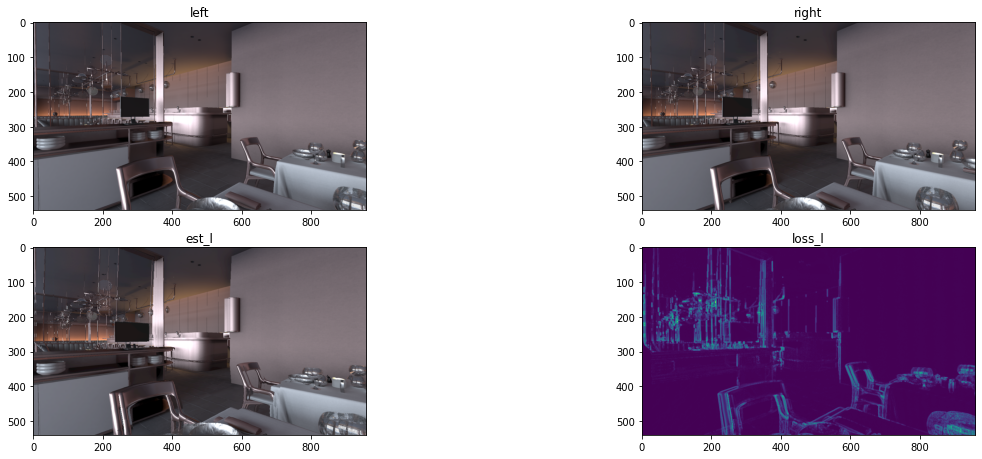

In [11]:
torch.cuda.empty_cache()
DEVICE = 'cuda:0'
DATA_DIR = "/data"
NEW_LIST = 'IRS/lists/IRS_restaurant_metal_test.list'
BATCH_SIZE = 2
NUM_WORKERS = 1
dataset = IRSDataset(txt_file=NEW_LIST, root_dir=DATA_DIR, phase='visualize')
train_loader = DataLoader(dataset, batch_size = BATCH_SIZE, \
                                shuffle = True, num_workers = NUM_WORKERS, \
                                pin_memory = True)
net = DispNetC(batchNorm=False, input_channel=3, maxdisp=30).to(DEVICE)
batch = next(iter(train_loader))
per_loss = PerceptualLoss([PerceptualLoss.L1], DEVICE)
im_l = batch['img_left'].to(DEVICE)
im_r = batch['img_right'].to(DEVICE)
est_l, loss_l = per_loss(im_l, im_r, batch['gt_disp'].to(DEVICE))

fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(5,2,1)
plt.title('left')
ax1.imshow(im_l[0].cpu().moveaxis(0, -1))
ax2 = fig.add_subplot(5,2,2)
plt.title('right')
ax2.imshow(im_r[0].cpu().moveaxis(0, -1))
ax3 = fig.add_subplot(5,2,3)
plt.title('est_l')
ax3.imshow(est_l[0].cpu().moveaxis(0, -1))
ax3 = fig.add_subplot(5,2,4)
plt.title('loss_l')
ax3.imshow(loss_l[0].cpu().moveaxis(0, -1))





In [3]:
# Main training loop
LR = 0.0002
DEVICE = 'cuda:0'
DATA_DIR = "/data"
TRAIN_LIST = 'IRS/lists/Restaurant_TRAIN.list'
TEST_METAL_LIST = 'IRS/lists/IRS_restaurant_metal_test.list'
PRETRAIN_CHECKPOINT = None
BATCH_SIZE = 2
MAX_DISP = 200
NUM_WORKERS = 4
EPOCHS = 1

per_loss = PerceptualLoss([PerceptualLoss.L1], DEVICE)
criterion = SSLCriterion([per_loss])
trainer = DisparityTrainer(
    lr=LR,
    device=DEVICE,
    trainlist=TRAIN_LIST,
    vallist=TEST_METAL_LIST,
    datapath=DATA_DIR,
    batch_size=BATCH_SIZE,
    maxdisp=MAX_DISP,
    criterion=criterion,
    pretrain=PRETRAIN_CHECKPOINT,
    num_workers=NUM_WORKERS
)

for epoch in range(EPOCHS):
    trainer.train_one_epoch(epoch)
    trainer.validate()
    

/project/IRS/networks/DispNetC.py:117: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  kaiming_normal(m.weight.data)
2022-04-17 18:44:23,691 [4048939679.py:123] INFO learning rate of epoch 0: 0.000200.
/project/IRS/utils/preprocess.py:154: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1050.)
  gs[0].mul_(0.299).add_(0.587, gs[1]).add_(0.114, gs[2])
/project/IRS/utils/preprocess.py:154: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1050.)
  gs[0].mul_(0.299).add_(0.587, gs[1]).add_(0.114, gs[2])
/project/IRS/utils/preprocess.py:154: UserWarning: This o

KeyboardInterrupt: 